In [ ]:
from pathlib import Path
import seaborn as sn
import os
import sys
sys.path.append(str(Path.cwd().parent))
from src.utils.gcs_utils import set_environement_variable
from sklearn.metrics import classification_report

is_env_variables_set = set_environement_variable()
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'path to auth.json file'

from src.utils import envs 
e=envs.Envs()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Using Default Env Variable:GCS
Using Default Env Variable:LOAD_MODELS
Using Default Env Variable:GCS_IMAGE_BUCKET
Using Default Env Variable:USER_DERMINATOR
Using Default Env Variable:PW_DERMINATOR


# 1.  Read Test Predictions

In [3]:
# binary test set: gs://oro-ds-test-bucket/sdd_acne_files/mlflow_prod/58d36d6e59604d1d83cf1b3c36298b89/artifacts/files/bit-0-test_predictions.csv
# binary train set: gs://oro-ds-test-bucket/sdd_acne_files/mlflow_prod/58d36d6e59604d1d83cf1b3c36298b89/artifacts/files/bit-0-train_predictions.csv

In [53]:
df_preds = pd.read_csv('gs://oro-ds-test-bucket/sdd_acne_files/mlflow_prod/58d36d6e59604d1d83cf1b3c36298b89/artifacts/files/bit-0-test_predictions.csv')
print(f'There are {df_preds.shape[0]} images in the test set.')
df_preds.head()

There are 1630 images in the test set.


,prob_acne,prob_not_acne,filename,label,predicted,preds
0,6.163755e-02,0.938362,resized/5011/1ED60E6C75/ailment_photos/AP-11bc...,not_acne,not_acne,1
1,3.710730e-06,0.999996,resized/18394/1F5103F089/ailment_photos/AP-6ac...,not_acne,not_acne,1
2,8.323809e-03,0.991676,resized/4227/0DF639EED1/ailment_photos/AP-76d4...,not_acne,not_acne,1
3,2.791493e-08,1.000000,resized/19649/C831D3ECE0/ailment_photos/AP-dc2...,not_acne,not_acne,1
4,2.128008e-06,0.999998,resized/19267/A4196CCA45/ailment_photos/AP-d51...,not_acne,not_acne,1


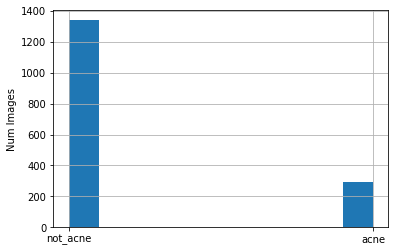

In [54]:
df_preds['label'].hist()
plt.ylabel('Num Images')
plt.show()

In [55]:
df_preds['label'].value_counts()

not_acne    1338
acne         292
Name: label, dtype: int64

In [56]:
#df_dataset = pd.read_csv('bit-dataset.csv')
df_dataset = pd.read_csv('gs://oro-ds-test-bucket/shanel_test/raw_image_paths_from_db.csv')
df_dataset.rename(columns={'pathBucketImage':'filename'}, inplace=True)
df_dataset['filename'] = 'resized/' + df_dataset['filename'].astype(str)
df_dataset.head()

,Unnamed: 0,filename,labelledby,reviewedby,acne_comedos,acne_cystic,acne_mixed,acne_scars,acne_excoriated,rosacea_erythemato_telangiectasique,...,keratosis_pilaris,molluscum,folliculitis,melanonychia,nevus,lichen_planus,chelitis_actinic,cheilitis_eczematous,urticaria,unspecified
0,0,resized/7830/646B3FD8EE/ailment_photos/AP-c1bb...,Guillemette Salomon,NaN,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,resized/9369/005F4BC9BC/ailment_photos/AP-231d...,Guillemette Salomon,NaN,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,2,resized/936/E617F7DF5F/ailment_photos/AP-cc6f0...,Guillemette Salomon,NaN,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,3,resized/9716/7C41A121CF/ailment_photos/AP-5643...,Guillemette Salomon,NaN,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,4,resized/9718/BF893BCA47/ailment_photos/AP-0743...,Guillemette Salomon,NaN,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [57]:
df_preds['acne'] =  df_preds['label']=='acne'

# 2. Merge Predictions with Disease Types

In [58]:
df_preds = df_preds.merge(df_dataset, how='left', on='filename')


In [59]:
df_preds.head()

,prob_acne,prob_not_acne,filename,label,predicted,preds,acne,Unnamed: 0,labelledby,reviewedby,...,keratosis_pilaris,molluscum,folliculitis,melanonychia,nevus,lichen_planus,chelitis_actinic,cheilitis_eczematous,urticaria,unspecified
0,6.163755e-02,0.938362,resized/5011/1ED60E6C75/ailment_photos/AP-11bc...,not_acne,not_acne,1,False,24744,Guillemette Salomon,NaN,...,False,False,False,False,False,False,False,False,False,False
1,3.710730e-06,0.999996,resized/18394/1F5103F089/ailment_photos/AP-6ac...,not_acne,not_acne,1,False,14164,Guillemette Salomon,NaN,...,False,False,True,False,False,False,False,False,False,False
2,8.323809e-03,0.991676,resized/4227/0DF639EED1/ailment_photos/AP-76d4...,not_acne,not_acne,1,False,23473,Guillemette Salomon,NaN,...,False,False,False,False,True,False,False,False,False,False
3,2.791493e-08,1.000000,resized/19649/C831D3ECE0/ailment_photos/AP-dc2...,not_acne,not_acne,1,False,16148,Guillemette Salomon,NaN,...,False,False,False,False,False,False,False,False,False,False
4,2.128008e-06,0.999998,resized/19267/A4196CCA45/ailment_photos/AP-d51...,not_acne,not_acne,1,False,15707,Guillemette Salomon,NaN,...,False,False,False,False,False,False,False,False,False,False


In [60]:
columns = ['rosacea_inflammatory','rosacea_erythemato_telangiectasique','peri_oral_dermatitis',
                'seborrheic_keratosis','psoriasis_vulgar','seborrheic_dermatitis','nummular_eczema',
                'tinea_versicolor','chronic_hand_eczema','vulgar_warts','folliculitis','alopecia_androgenic',
                'dyshidrosis','nevus','melasma','alopecia_areata','intertrigo','urticaria','vitiligo','keratosis_pilaris',
                'molluscum','cheilitis_eczematous','tinea_corporis','prurigo_nodularis','actinic_keratosis',
                'genital_warts','plane_warts','pityriasis_rosae','melanonychia','psoriasis_pustular_palmoplantar',
                'granuloma_annulare','psoriasis_guttate','lichen_simplex_chronicus','shingles','herpes_simplex', 'acne_cystic', 'acne_scars', 'acne_mixed', 'acne_excoriated', 'acne_comedos']

In [61]:
df_preds['diseases'] = df_preds[columns].apply(lambda x: tuple(df_preds[columns].columns[np.argwhere(x.values== True).flatten()], ), axis=1)

In [62]:
df_preds['one_tag'] = df_preds['diseases'].apply(lambda x : True if len(x)==1 else False)

In [63]:
#df_preds = df_preds[df_preds['one_tag']==True]

In [64]:
#df_preds.drop(columns=columns, inplace=True)
df_preds.head()

,prob_acne,prob_not_acne,filename,label,predicted,preds,acne,Unnamed: 0,labelledby,reviewedby,...,folliculitis,melanonychia,nevus,lichen_planus,chelitis_actinic,cheilitis_eczematous,urticaria,unspecified,diseases,one_tag
0,6.163755e-02,0.938362,resized/5011/1ED60E6C75/ailment_photos/AP-11bc...,not_acne,not_acne,1,False,24744,Guillemette Salomon,NaN,...,False,False,False,False,False,False,False,False,"(prurigo_nodularis,)",True
1,3.710730e-06,0.999996,resized/18394/1F5103F089/ailment_photos/AP-6ac...,not_acne,not_acne,1,False,14164,Guillemette Salomon,NaN,...,True,False,False,False,False,False,False,False,"(folliculitis,)",True
2,8.323809e-03,0.991676,resized/4227/0DF639EED1/ailment_photos/AP-76d4...,not_acne,not_acne,1,False,23473,Guillemette Salomon,NaN,...,False,False,True,False,False,False,False,False,"(nevus,)",True
3,2.791493e-08,1.000000,resized/19649/C831D3ECE0/ailment_photos/AP-dc2...,not_acne,not_acne,1,False,16148,Guillemette Salomon,NaN,...,False,False,False,False,False,False,False,False,"(alopecia_androgenic,)",True
4,2.128008e-06,0.999998,resized/19267/A4196CCA45/ailment_photos/AP-d51...,not_acne,not_acne,1,False,15707,Guillemette Salomon,NaN,...,False,False,False,False,False,False,False,False,"(peri_oral_dermatitis,)",True


# 3. Analysis of Misclassified Images

In [65]:
def plot_misclassified_bar_chart(df_preds, df_misclassify, misclassified_label='acne', fig_size= 7 ):    
    if misclassified_label=='acne':
        label ='not_acne'
    else:
        label='acne'
    plt.figure(figsize=(23,fig_size))
    all_values= df_preds[df_preds['label']==label]['diseases'].value_counts()
    values = df_misclassify[df_misclassify['predicted']==misclassified_label]['diseases'].value_counts().sort_index()
    for idx in all_values.index:
        if idx not in values:
            values = values.append(pd.Series([0],[idx]))
    values= values[all_values.index]
    all_values.plot(kind='bar', label='all not acne images', color='orange')
    values.plot(kind='bar', label='misclassified not acne images', color='b')
    plt.ylabel('Num of Images')
    plt.xlabel('Not acne disease')
    for index, data in enumerate(values):
        if data!=0:
            plt.text(x=index, y=data+0.1, s=f'{data}', fontdict=dict(fontsize=10))

    for index, data in enumerate(all_values):
        plt.text(x=index, y=data+0.1, s=f'{data}', fontdict=dict(fontsize=10))
    plt.legend()
    plt.show()

Below, we have the total number of 'not acne' and 'acne' images.

In [66]:
df_preds['label'].value_counts()

not_acne    1338
acne         292
Name: label, dtype: int64

In [67]:
print(classification_report(df_preds['label'], df_preds['predicted'], target_names= ['acne', 'not_acne', ], output_dict=False))

              precision    recall  f1-score   support

        acne       0.79      0.88      0.83       292
    not_acne       0.97      0.95      0.96      1338

    accuracy                           0.94      1630
   macro avg       0.88      0.91      0.90      1630
weighted avg       0.94      0.94      0.94      1630



Text(32.59375, 0.5, 'True Label')

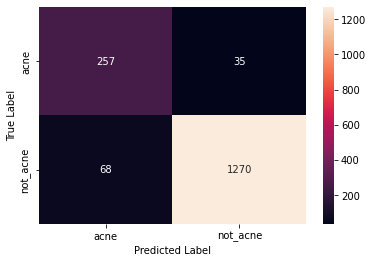

In [68]:
matrix = confusion_matrix(df_preds['label'], df_preds['predicted'])
index = ['acne', 'not_acne', ]
df_cm = pd.DataFrame(matrix, index=index, columns=index)
f = plt.figure()
sn.heatmap(df_cm, annot=True, fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [69]:
df_misclassify = df_preds[df_preds['label']!=df_preds['predicted']].reset_index(drop=True)

## 3.1 Images misclassified as acne

In [70]:
print(f"In total, {df_misclassify[df_misclassify['predicted']=='acne'].shape[0]} not_acne images were classified as acne.")

In total, 68 not_acne images were classified as acne.


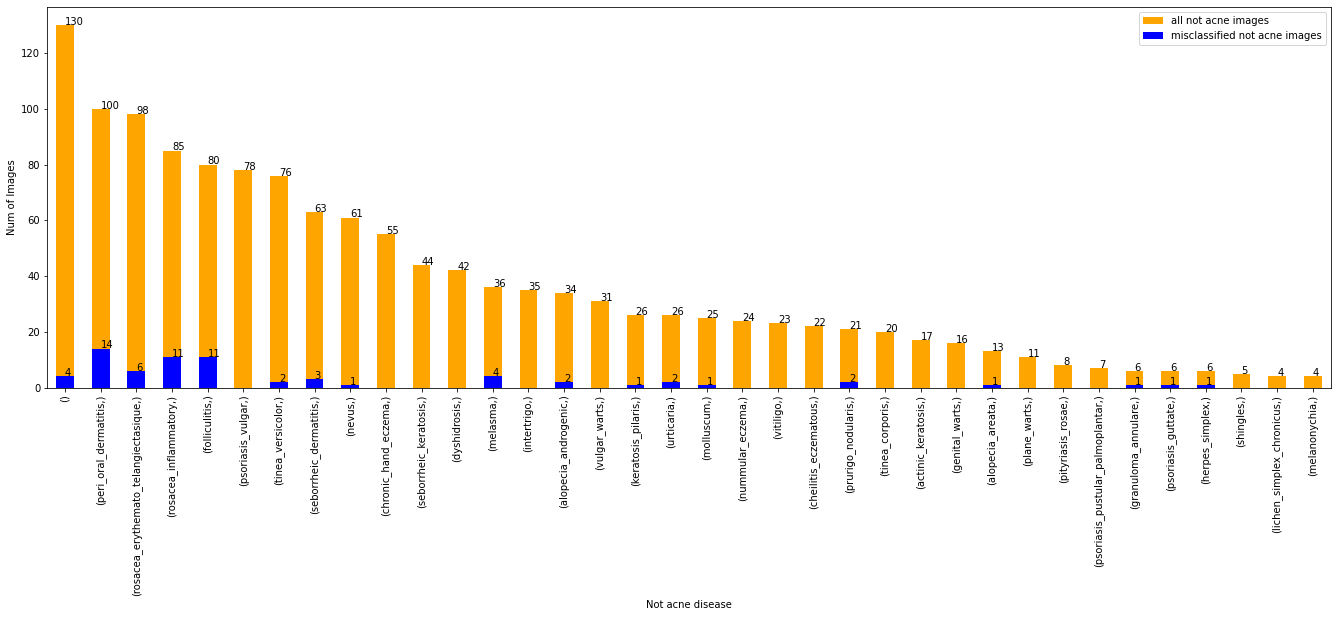

In [71]:
df_misclassify = df_preds[df_preds['label']!=df_preds['predicted']].reset_index(drop=True)
plot_misclassified_bar_chart(df_preds, df_misclassify,misclassified_label='acne' )

Below, we see the average probabilties per disease.

In [72]:
df_misclassify[df_misclassify['predicted']=='acne'].groupby(['diseases'])['prob_acne'].agg(['mean', 'count']).sort_values('count', ascending=False)

,mean,count
diseases,,
"(peri_oral_dermatitis,)",0.871598,14
"(folliculitis,)",0.913633,11
"(rosacea_inflammatory,)",0.938458,11
"(rosacea_erythemato_telangiectasique,)",0.847804,6
(),0.857249,4
"(melasma,)",0.794191,4
"(seborrheic_dermatitis,)",0.709918,3
"(tinea_versicolor,)",0.874019,2
"(prurigo_nodularis,)",0.999284,2


## Images misclassified as not_acne

In [73]:
print(f"In total, {df_misclassify[df_misclassify['predicted']=='not_acne'].shape[0]} acne images were classified as not_acne.")

In total, 35 acne images were classified as not_acne.


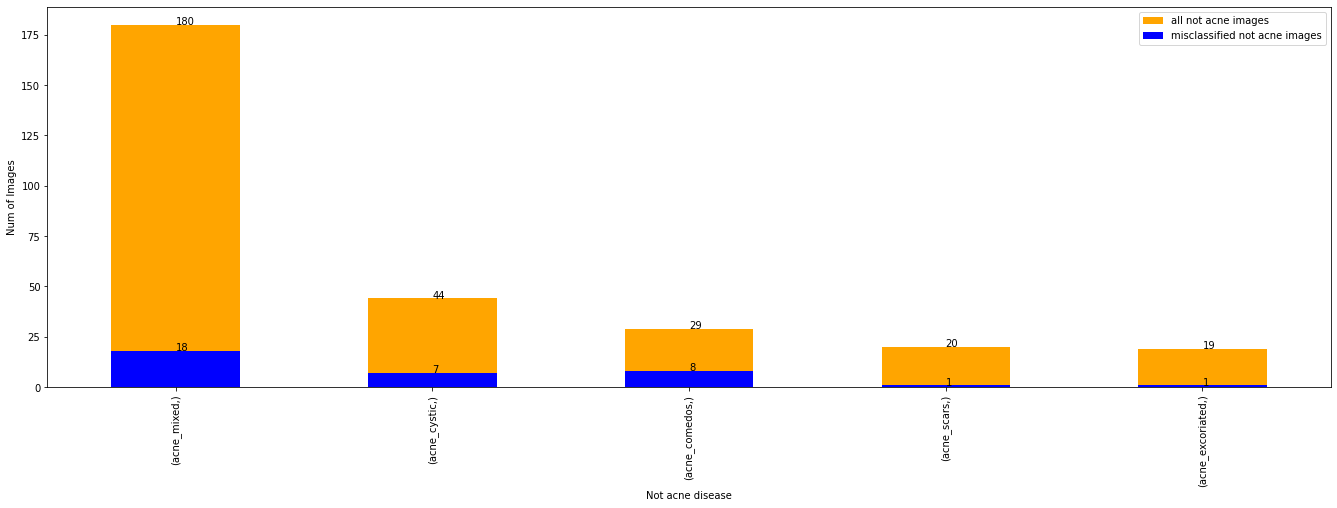

In [74]:
df_misclassify = df_preds[df_preds['label']!=df_preds['predicted']].reset_index(drop=True)
plot_misclassified_bar_chart(df_preds, df_misclassify,misclassified_label='not_acne' ,fig_size=7)


In [75]:
df_misclassify[df_misclassify['predicted']=='not_acne'].groupby(['diseases'])['prob_not_acne'].agg(['mean', 'count']).sort_values('count', ascending=False)

,mean,count
diseases,,
"(acne_mixed,)",0.893852,18
"(acne_comedos,)",0.971873,8
"(acne_cystic,)",0.963157,7
"(acne_excoriated,)",0.559959,1
"(acne_scars,)",0.999600,1
